In [1]:
# %run plot_TOPAZ_bias.py

In [1]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import yaml
import pickle as pkl
from datetime import datetime
from datetime import timedelta
from glob import glob
import netCDF4 as nc4

from src.utils import modif_plot
import src.utils.load_config as load_config
import src.data_preparation.load_data as load_data
import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()

## Import TOPAZ4b 23

In [2]:
# -------------- load --------------------------
# Path to config file
file_config = '../config/config_default_2023.yaml'
nosit_dir, withsit_dir, _, forcing_bdir, pca_dir, res_dir, fig_dir, ml_dir, _ = load_config.load_filename(file_config)
timeofday, target_field, forcing_fields, covar_fields, lim_idm, lim_jdm, n_comp = load_config.load_config_params(file_config)

# load datasets from both TOPAZ versions
print('Loading TOPAZ datasets...')
# filename = os.path.join(rootdir, pca_dir, f"{target_field}_TOPAZ4c_2011_2019.nc")
# X_f, chrono_f = load_data.load_nc(filename, f'{target_field}', True)
# chrono_f = pd.DataFrame({'date':pd.to_datetime(X_f['time'].to_numpy())})

# filename = os.path.join(rootdir, pca_dir, f"{target_field}_TOPAZ4b_2011_2019.nc")
filename = os.path.join(rootdir, pca_dir, f"{target_field}_TOPAZ4b23_2011_2022_adjSIC.nc")
X_a, chrono_a = load_data.load_nc(filename, f'{target_field}', True)
# chrono_a = pd.DataFrame({'date':pd.to_datetime(X_a['time'].to_numpy())})

# LOAD FREE RUN TOPAZ4B
filename = os.path.join(rootdir, pca_dir, f"{target_field}_TOPAZ4b23_2011_2022_FreeRun_adjSIC.nc")
X_fr, chrono_fr = load_data.load_nc(filename, f'{target_field}', True)

Loading TOPAZ datasets...


In [3]:
# --------------- load si concentration  -------------

print('Loading TOPAZ datasets...')
# filename = os.path.join(rootdir, pca_dir, f"siconc_TOPAZ4c_2011_2019.nc")
# siconc_f, chronosc_f = load_data.load_nc(filename, f'siconc', True)
# chrono_f = pd.DataFrame({'date':pd.to_datetime(X_f['time'].to_numpy())})

filename = os.path.join(rootdir, pca_dir, f"siconc_TOPAZ4b23_2011_2022.nc")
siconc_a, chronosc_a = load_data.load_nc(filename, f'siconc', True)

# LOAD FREE RUN TOPAZ4B
filename = os.path.join(rootdir, pca_dir, f"siconc_TOPAZ4b23_2011_2022_FreeRun_adjSIC.nc")
siconc_fr, chronosc_fr = load_data.load_nc(filename, f'siconc', True)

print('Done !')

Loading TOPAZ datasets...
Done !


## Get bias - compute for Sea Ice Concentration > 15%

In [4]:
# --------------- get bias ---------------------

# TOPAZ4b contains all 2010, TOPAZ4c contains only the ~2 last months
chrono_e = chrono_fr.merge(chrono_a)  # only keep common times between 2 versions of TOPAZ

# Xfm = X_f.mean(dim=('y','x')).compute()
Xam = X_a.mean(dim=('y','x')).compute()
# Xem = Xam - Xfm

Xfrm = X_fr.mean(dim=('y','x')).compute()
Xfrm_c15 = X_fr.where(siconc_fr>.15).mean(dim=('y','x')).compute()

# Xfm_c15 = X_f.where(siconc_f>.15).mean(dim=('y','x')).compute()
Xam_c15 = X_a.where(siconc_fr>.15).mean(dim=('y','x')).compute()


# Xem_c15 = Xam_c15 - Xfm_c15
Xem_fr = Xam - Xfrm
# Xem_fr = Xfrm - Xam

Xem_fr_c15 = Xam_c15 - Xfrm_c15
# Xem_fr_c15 =  Xfrm_c15 - Xam_c15

In [6]:
# volume
vol_fr = (X_fr.where(siconc_fr>.15) * siconc_fr).mean(dim=('y','x')).compute()


In [7]:
vol_a = (X_a.where(siconc_a>.15) * siconc_a).mean(dim=('y','x')).compute()


In [8]:
# Xfm_c0 = X_f.where(siconc_f>.0).mean(dim=('y','x')).compute()
Xam_c0 = X_a.where(siconc_a>.0).mean(dim=('y','x')).compute()
# Xem_c0 = Xam_c0 - Xfm_c0

## Import CS2SMOS

In [5]:
# get CS2SMOS
odir = f'{rootdir}Leo/SIT_observations/CS2SMOS/results/'
# ofile = f'CS2SMOS_SIT_mean_SIC15_20101115_20210415.nc'
# ofile = f'CS2SMOS_SIT_mean_20101115_20210415.nc'
# ofile = f'CS2SMOS_SIT_SIC_20101115_20210415.nc'
ofile = 'CS2SMOS_v205_SIT_20101101_20230415.nc'

# nc = xr.open_mfdataset(f'{odir}{ofile}', combine='nested', concat_dim='time')
nc = nc4.Dataset(f'{odir}{ofile}', mode='r')
cs2 = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['analysis_sea_ice_thickness']
# cs2 = nc['analysis_sea_ice_thickness']
cs2 = cs2.mean(('y','x'))

## Import Landy 2022

In [6]:
odir = f'{rootdir}Leo/SIT_observations/Landy_2022/results/'
# ofile = 'Landy22_SIT_mean_SIC15_20101010_20200725.nc'
ofile = 'Landy22_SIT_mean_SIC15_20101010_20200725_reproj_TP4.nc'

# nc = xr.open_mfdataset(f'{odir}{ofile}', combine='nested', concat_dim='time')
nc = nc4.Dataset(f'{odir}{ofile}', mode='r')
sit_l = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['Sea_Ice_Thickness']
situ_l = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['Sea_Ice_Thickness_Uncertainty']
vol_l = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['Sea_Ice_Volume']

In [7]:
chrono_l = pd.DataFrame({'date':pd.to_datetime(sit_l.t.to_numpy())})

# Plot

In [8]:
fig_dir = 'Leo/results/bin_fig/'

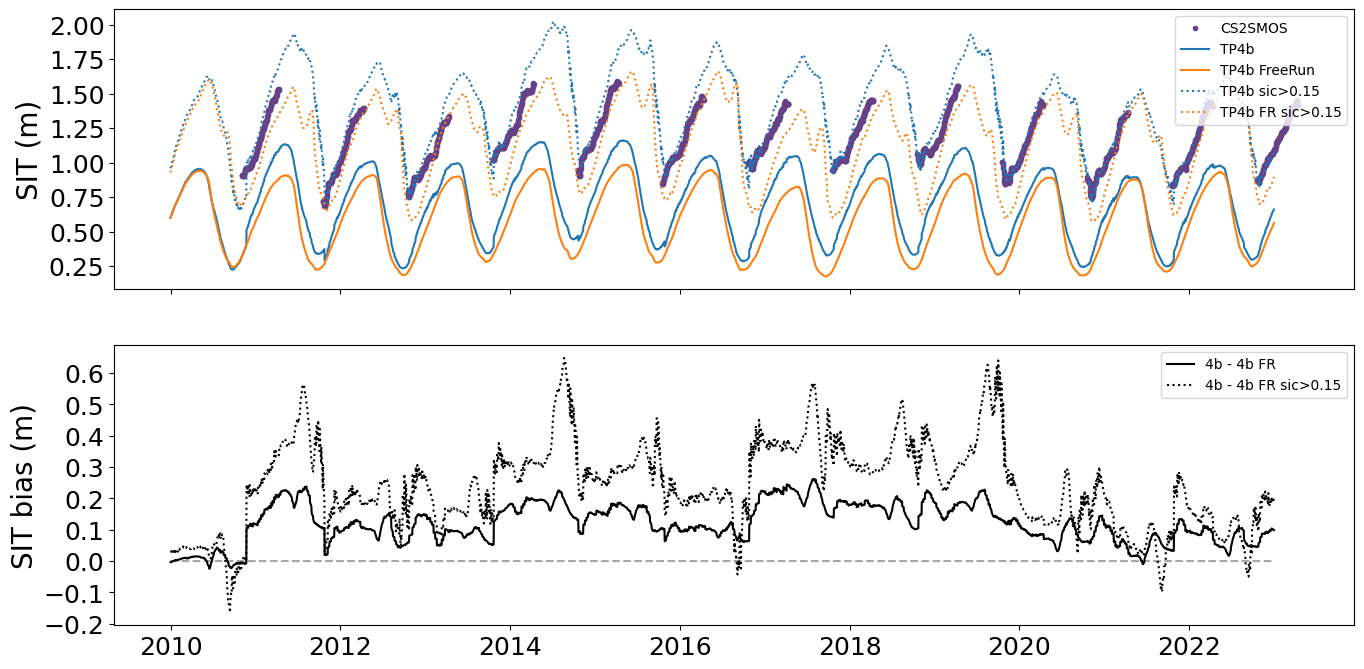

In [12]:
# ----------- plot -------------------

fig, (ax, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(16, 8))
ax.plot(cs2.time, cs2, marker='.', c='#664186', label='CS2SMOS', ls='')
# ax.plot(chrono_f, Xfm, label='TP4c')
ax.plot(chrono_a, Xam, label='TP4b',color='#1f77b4')
ax.plot(chrono_fr, Xfrm, label='TP4b FreeRun', color='#ff7f0e')


# ax.plot(chrono_f, Xfm_c0, label='TOPAZ4c c0', color='#1f77b4', ls='--')
# ax.plot(chrono_a, Xam_c0, label='TOPAZ4b c0', color='#FFA500', ls='--')

# ax.plot(chrono_f, Xfm_c15, label='TP4c sic>0.15', color='#1f77b4', ls=':')
ax.plot(chrono_a, Xam_c15, label='TP4b sic>0.15', color='#1f77b4', ls=':')
ax.plot(chrono_fr, Xfrm_c15, label='TP4b FR sic>0.15', color='#ff7f0e', ls=':')


ax.set_ylabel('SIT (m)')
ax.set_xticklabels('')

ax2.plot(chrono_a, [0]*len(chrono_a), '--', c ='grey', alpha=.7)
# ax2.plot(chrono_e, Xem, 'k', label='4b - 4c')
# ax2.plot(chrono_e, Xem_c0, 'r--', label='siconc > 0')
# ax2.plot(chrono_e, Xem_c15, 'k:', label='4b - 4c sic>0.15')
ax2.plot(chrono_e, Xem_fr, c='k', label='4b - 4b FR')  # '#2ca02c'
ax2.plot(chrono_e, Xem_fr_c15, c='k', ls=':', label='4b - 4b FR sic>0.15')


ax2.set_xlim(ax.get_xlim())
ax2.set_ylabel(f'SIT bias (m)')

ax.legend()
ax2.legend()

modif_plot.resize(fig, s=18)


savefig = False
if savefig:
    filename = f'TOPAZ4b_c_bias_CS2SMOS_4bFreeRun_SIC15.png'
    plt.savefig(f"{rootdir}{fig_dir}{filename}", dpi=400) # , facecolor='white')
    print(f'Saved as {rootdir}{fig_dir}{filename}')

In [98]:
cs2.time[:-102]  # remove data in 2023

<xarray.DataArray 'time' (time: 2185)>
array(['2010-11-04T12:00:00.000000000', '2010-11-05T12:00:00.000000000',
       '2010-11-06T12:00:00.000000000', ..., '2022-12-29T12:00:00.000000000',
       '2022-12-30T12:00:00.000000000', '2022-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2010-11-04T12:00:00 ... 2022-12-31T12:00:00

In [16]:
plot_landy = False
savefig = True # False

In [10]:
from matplotlib import dates

Saved as /scratch/project_465000269/edelleo1/Leo/results/bin_fig/TOPAZ4b23_bias_CS2SMOS_4bFR_SIC15_adjSIC_sub01.png


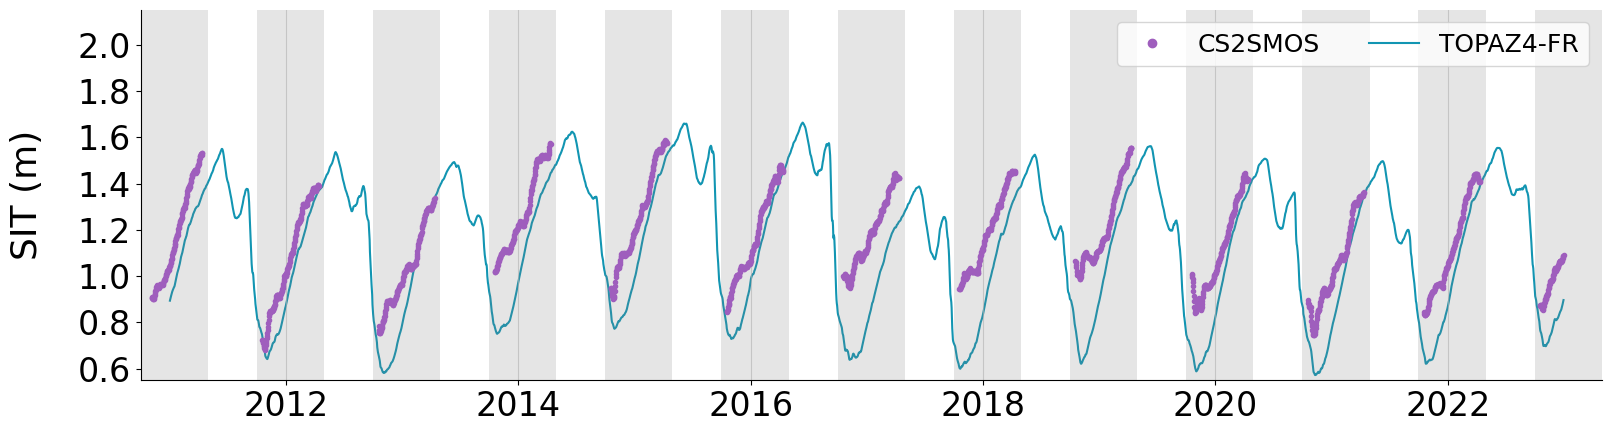

In [24]:
# ----------- plot -------------------

# fig, (ax, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(16, 8), constrained_layout=True)
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(16, 8), constrained_layout=True)

axes[0].plot(cs2.time[:-102], cs2[:-102], marker='.', c='#9f5ebd', label='CS2SMOS', ls='', zorder=5)  # #664186

# axes[0].plot(chrono_a, Xam_c15, label='TOPAZ4-RA', lw=2, ls='--', color='k', zorder=10)
axes[0].plot(chrono_fr, Xfrm_c15, label='TOPAZ4-FR', color='#1295B2', zorder=0)  # #ff7f0e


if plot_landy:
    axes[0].plot(chrono_l, sit_l.data, label='Landy', color='green')


axes[0].set_ylabel('SIT (m)')
# axes[0].set_xticklabels('')
axes[0].xaxis.grid(alpha=0.6)
# axes[0].yaxis.grid(alpha=0.6)
axes[0].set_xlim([datetime(2010,10,1), datetime(2023,4,30)])
axes[0].set_ylim([0.55,2.15])

# axes[0].spines[['right', 'top', 'bottom']].set_visible(False)
# axes[0].tick_params(labelbottom=False, bottom=False)


axes[0].spines[['right', 'top']].set_visible(False)
axes[0].tick_params(labelbottom=True, bottom=True)


# grey alternative background (winter-summer)
for yr in range(2010, 2023):
    axes[0].axvspan(dates.date2num(datetime(yr,10,1)),
                    dates.date2num(datetime(yr+1,4,30)),
                    facecolor='grey', alpha=0.2)
    axes[1].axvspan(dates.date2num(datetime(yr,10,1)),
                    dates.date2num(datetime(yr+1,4,30)),
                    facecolor='grey', alpha=0.2)




axes[1].plot(chrono_a, [0]*len(chrono_a), '--', c ='grey', alpha=.7)
# ax2.plot(chrono_e, Xem_fr, c='k', label='4b - 4b FR')  # '#2ca02c'
axes[1].plot(chrono_e, -Xem_fr_c15, c='k', label='TOPAZ4-FR - TOPAZ4-RA') # #7E8A8A


axes[1].set_xlim(axes[0].get_xlim())
axes[1].set_ylabel(f'Bias SIT (m)')
axes[1].xaxis.grid(alpha=0.6)

axes[1].spines[['right', 'top']].set_visible(False)


axes[0].legend(fontsize=18, ncol=3, markerscale=2)
axes[-1].legend(fontsize=18, loc='lower right')  # lower left')

fig.align_ylabels(axes)

modif_plot.resize(fig, s=24)

# axes[1].set_visible(False)

if savefig:
    filename = f'TOPAZ4b23_bias_CS2SMOS_4bFR_SIC15_adjSIC.png'
    plt.savefig(f"{rootdir}{fig_dir}{filename}", dpi=150) # , facecolor='white')
    print(f'Saved as {rootdir}{fig_dir}{filename}')

## Simple plot for presentation

In [39]:
import datetime

In [55]:
new_lb

[Text(0, 0.0, '0.2'),
 '',
 Text(0, 0.4, '0.6'),
 '',
 Text(0, 0.8, '1.0'),
 '',
 Text(0, 1.2000000000000002, '1.4'),
 '',
 Text(0, 1.6, '1.8')]

In [83]:
type(new_lb[1])

matplotlib.text.Text

In [40]:
from matplotlib.text import Text

In [41]:
lb_mn = [Text(0, 0.0, '0'),
 Text(0, 0.2, ''),
 Text(0, 0.4, '0.4'),
 Text(0, 0.6000000000000001, ''),
 Text(0, 0.8, '0.8'),
 Text(0, 1.0, ''),
 Text(0, 1.2000000000000002, '1.2'),
 Text(0, 1.4000000000000001, ''),
 Text(0, 1.6, '1.6'),
 Text(0, 1.8, '')]

In [63]:
lb = ax.get_yticklabels()

In [73]:
lb[0]._text = ''

In [74]:
lb[1::2]._text = ''

AttributeError: 'list' object has no attribute '_text'

In [8]:
plot_landy = True

In [25]:
type(chrono_l)

pandas.core.frame.DataFrame

In [29]:
chrono_l.values.flatten().shape

(236,)

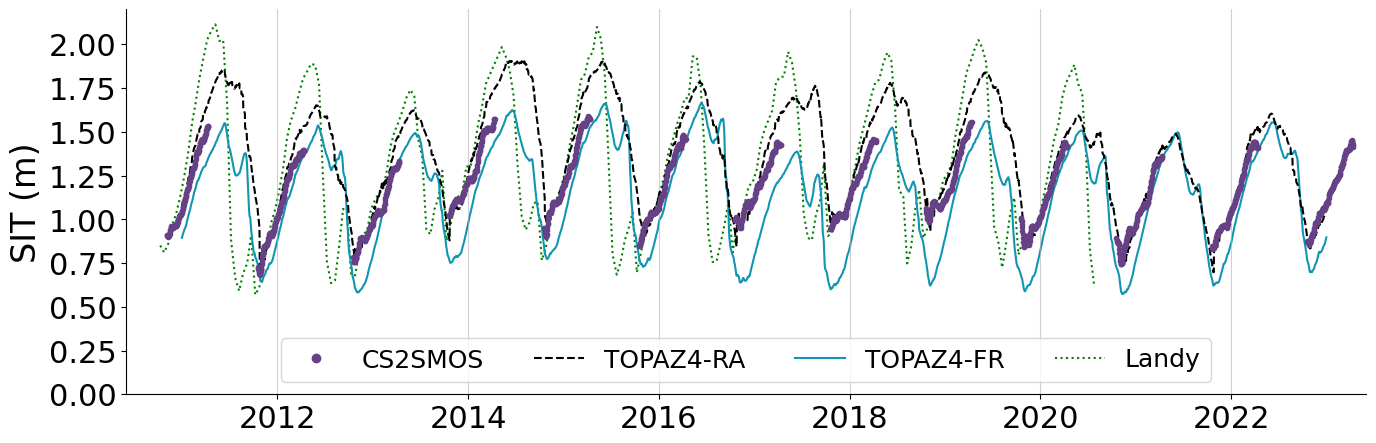

In [10]:
# ----------- plot -------------------

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 5))

ax.plot(cs2.time, cs2, marker='.', c='#664186', label='CS2SMOS', ls='', zorder=10)  # observations

ax.plot(chrono_a, Xam_c15, label='TOPAZ4-RA', color='k', zorder=5, ls='--')  # 1f77b4
ax.plot(chrono_fr, Xfrm_c15, label='TOPAZ4-FR', color='#1295B2', zorder=0)

if plot_landy:
    ax.plot(chrono_l, sit_l.data, label='Landy', color='green', zorder=-10, ls=':')
    # ax.fill_between(chrono_l.values.flatten(), (sit_l-situ_l).data, (sit_l+situ_l).data, 
    #                color='green', zorder=-10, alpha=0.2)
    

ax.set_ylabel('SIT (m)')

# ax.set_yticklabels(lb_mn)



ax.set_xlim([datetime(2010,6,1), datetime(2023,6,1)])
ax.set_ylim([0, 1.8])
ax.set_ylim([0, 2.2])


ax.xaxis.grid(alpha=0.6)

# ax2.set_xlim(ax.get_xlim())
ax.set_ylabel(f'SIT (m)')

ax.legend(ncol=4, fontsize=18, loc='lower center', markerscale=2)
# ax2.legend()
ax.spines[['right', 'top']].set_visible(False)


modif_plot.resize(fig, s=22)


savefig = False
if savefig:
    filename = f'TOPAZ4b23_FR_LandyUnc_CS2SMOS_01.png'
    plt.savefig(f"{rootdir}{fig_dir}{filename}", dpi=400) # , facecolor='white')
    print(f'Saved as {rootdir}{fig_dir}{filename}')

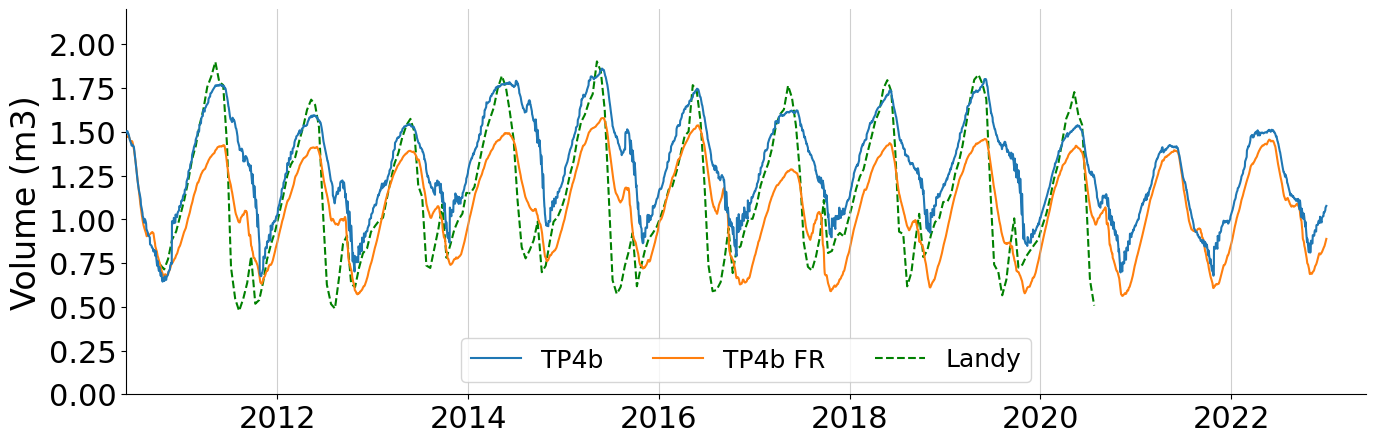

In [13]:
# ----------- plot -------------------

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 5))

# ax.plot(cs2.time, cs2, marker='.', c='#664186', label='CS2SMOS', ls='', zorder=10)  # observations


ax.plot(chrono_a, vol_a, label='TOPAZ4-RA', color='#1f77b4', zorder=5)
ax.plot(chrono_fr, vol_fr, label='TOPAZ4-FR', color='#ff7f0e', zorder=0)

if plot_landy:
    ax.plot(chrono_l, vol_l.data, label='Landy', color='green', zorder=-10, ls='--')


ax.set_ylabel('SIT (m)')

# ax.set_yticklabels(lb_mn)



ax.set_xlim([datetime(2010,6,1), datetime(2023,6,1)])
ax.set_ylim([0, 1.8])
ax.set_ylim([0, 2.2])


ax.xaxis.grid(alpha=0.6)

# ax2.set_xlim(ax.get_xlim())
ax.set_ylabel(f'Volume (m3)')

ax.legend(ncol=4, fontsize=18, loc='lower center', markerscale=2)
# ax2.legend()
ax.spines[['right', 'top']].set_visible(False)


modif_plot.resize(fig, s=22)


savefig = False
if savefig:
    filename = f'TOPAZ4b23_FR_Landy_CS2SMOS_01.png'
    plt.savefig(f"{rootdir}{fig_dir}{filename}", dpi=400) # , facecolor='white')
    print(f'Saved as {rootdir}{fig_dir}{filename}')